In [2]:
from rosemary import jpt_setup; jpt_setup()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import torch

from llava.model.builder import load_pretrained_model
from llava.mm_utils import process_images, get_model_name_from_path, process_images, tokenizer_image_token
from llava.eval.run_llava import eval_model

from llava.constants import (
    IMAGE_TOKEN_INDEX,
    DEFAULT_IMAGE_TOKEN,
    DEFAULT_IM_START_TOKEN,
    DEFAULT_IM_END_TOKEN,
    IMAGE_PLACEHOLDER,
)
from llava.conversation import conv_templates, SeparatorStyle
from llava.eval.run_llava import image_parser, load_images


In [4]:
model_path = "liuhaotian/llava-v1.5-7b"
# prompt = "What are the things I should be cautious about when I visit here?"
prompt = "What is unusual about this image?"
image_file = "https://llava-vl.github.io/static/images/view.jpg"
image_file = 'taxi_iron_man.jpeg'

args = type('Args', (), {
    "model_path": model_path,
    "model_base": None,
    "model_name": get_model_name_from_path(model_path),
    "query": prompt,
    "conv_mode": None,
    "image_file": image_file,
    "sep": ",",
    "temperature": 0,
    "top_p": None,
    "num_beams": 1,
    "max_new_tokens": 512
})()

args

## llava.eval.run_llava.py

In [43]:

model_name = get_model_name_from_path(args.model_path)
tokenizer, model, image_processor, context_len = load_pretrained_model(
    args.model_path, args.model_base, model_name
)


You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/gpfs/u/scratch/PTFM/PTFMqngp/miniconda3/envs/llava/lib/python3.10/site-packages/torch/_utils.py:777: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [6]:

qs = args.query
image_token_se = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN

print(qs)

if IMAGE_PLACEHOLDER in qs:
    if model.config.mm_use_im_start_end:
        qs = re.sub(IMAGE_PLACEHOLDER, image_token_se, qs)
    else:
        qs = re.sub(IMAGE_PLACEHOLDER, DEFAULT_IMAGE_TOKEN, qs)
else:
    if model.config.mm_use_im_start_end:
        qs = image_token_se + "\n" + qs
    else:
        qs = DEFAULT_IMAGE_TOKEN + "\n" + qs

qs, image_token_se, IMAGE_PLACEHOLDER, DEFAULT_IMAGE_TOKEN

What is unusual about this image?


('<image>\nWhat is unusual about this image?',
 '<im_start><image><im_end>',
 '<image-placeholder>',
 '<image>')

In [7]:
if "llama-2" in model_name.lower():
    conv_mode = "llava_llama_2"
elif "mistral" in model_name.lower():
    conv_mode = "mistral_instruct"
elif "v1.6-34b" in model_name.lower():
    conv_mode = "chatml_direct"
elif "v1" in model_name.lower():
    conv_mode = "llava_v1"
elif "mpt" in model_name.lower():
    conv_mode = "mpt"
else:
    conv_mode = "llava_v0"


if args.conv_mode is not None and conv_mode != args.conv_mode:
    print(
        "[WARNING] the auto inferred conversation mode is {}, while `--conv-mode` is {}, using {}".format(
            conv_mode, args.conv_mode, args.conv_mode
        )
    )
else:
    args.conv_mode = conv_mode
    
model_name, conv_mode, args.conv_mode

('llava-v1.5-7b', 'llava_v1', 'llava_v1')

In [8]:

conv = conv_templates[args.conv_mode].copy()
conv.append_message(conv.roles[0], qs)
conv.append_message(conv.roles[1], None)
prompt = conv.get_prompt()

prompt

"A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: <image>\nWhat is unusual about this image? ASSISTANT:"

[(570, 380)]


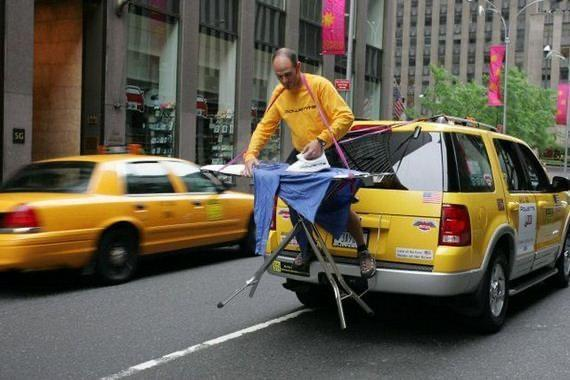

In [9]:

image_files = image_parser(args)
images = load_images(image_files)
image_sizes = [x.size for x in images]

print(image_sizes)
images[0]

In [10]:

images_tensor = process_images(
    images,
    image_processor,
    model.config
).to(model.device, dtype=torch.float16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


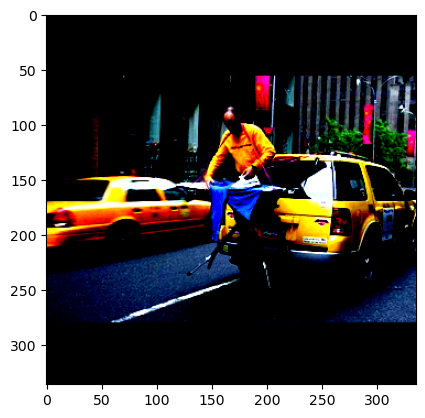

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(images_tensor[0].cpu().numpy().transpose((1, 2, 0)).astype(np.float32))

In [12]:
## tokenizer_image_token -> substitute <image> with -200.
input_ids = (
    tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt")
    .unsqueeze(0)
    .cuda()
)

l1 = torch.tensor([[    1,   319, 13563,  1546,   263, 12758,  5199,   322,   385, 23116,
         21082, 20255, 29889,   450, 20255,  4076,  8444, 29892, 13173, 29892,
           322,  1248,   568,  6089,   304,   278,  5199, 29915, 29879,  5155,
         29889,  3148,  1001, 29901, 29871, ]])
l2 = torch.tensor([[29871,    13,  5618,   526,
           278,  2712,   306,   881,   367,   274,  1300,  2738,  1048,   746,
           306,  6493,  1244, 29973,   319,  1799,  9047, 13566, 29901]])
tokenizer.decode(l1[0]), tokenizer.decode(l2[0])

("<s> A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions. USER: ",
 '\nWhat are the things I should be cautious about when I visit here? ASSISTANT:')

In [17]:

with torch.inference_mode():
    output_ids = model.generate(
        input_ids,
        images=images_tensor,
        image_sizes=image_sizes,
        do_sample=True if args.temperature > 0 else False,
        temperature=args.temperature,
        top_p=args.top_p,
        num_beams=args.num_beams,
        max_new_tokens=args.max_new_tokens,
        use_cache=True,
        return_dict=True,
    )


outputs = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()
outputs

[llava_arch.LlavaMetaForCausalLM.prepare_inputs_labels_for_multimodal] images: torch.Size([1, 3, 336, 336])
[llava_arch.LlavaMetaForCausalLM.prepare_inputs_labels_for_multimodal] image_features: torch.Size([1, 576, 4096])
[llava_arch.LlavaMetaForCausalLM.prepare_inputs_labels_for_multimodal] image_token_indices: [-1, 35, 50]
LlavaLlamaForCausalLM.forward: inputs_embeds.shape: torch.Size([1, 625, 4096])


"The unusual aspect of this image is that a man is sitting on a folding chair and ironing clothes while a car drives by. This is not a typical scene, as ironing clothes is usually done indoors, in a more controlled environment. The man's position on the side of the road, combined with the presence of a yellow taxi, suggests that this might be an unconventional or spontaneous situation. It is also worth noting that the man is wearing a yellow shirt, which adds to the distinctiveness of the scene."

In [44]:

input_output_ids = torch.cat([input_ids, output_ids], dim=1)

with torch.inference_mode():
    outputs = model.forward(
        input_output_ids,
        images=images_tensor,
        image_sizes=image_sizes,
        use_cache=True,
        output_attentions=True,
        output_hidden_states=True,
        return_dict=True,
    )



[llava_arch.LlavaMetaForCausalLM.prepare_inputs_labels_for_multimodal] images: torch.Size([1, 3, 336, 336])
[llava_arch.LlavaMetaForCausalLM.prepare_inputs_labels_for_multimodal] image_features: torch.Size([1, 576, 4096])
[llava_arch.LlavaMetaForCausalLM.prepare_inputs_labels_for_multimodal] image_token_indices: [-1, 35, 168]
LlavaLlamaForCausalLM.forward: inputs_embeds.shape: torch.Size([1, 743, 4096])


In [45]:
x = input_output_ids.detach().cpu().clone()[0]

im_ind = torch.where(x == IMAGE_TOKEN_INDEX)[0].tolist()[0]
tokens = tokenizer.convert_ids_to_tokens(x[:im_ind]) + ['im_'+str(i) for i in range((outputs.attentions[0].shape[-1]-len(x)+1))] + tokenizer.convert_ids_to_tokens(x[im_ind+1:])
len(tokens)


743

In [61]:
n = 1000
attns = [torch.mean(outputs.attentions[-1][:,:,:n,:n], dim=1, keepdim=True)]
toks = tokens[:n]
attns[0].shape, len(toks)

(torch.Size([1, 1, 200, 200]), 200)

In [62]:
from bertviz import head_view

head_view(attns, toks[::-1])


<IPython.core.display.Javascript object>

In [34]:
from bertviz import head_view, model_view
from transformers import AutoModel, AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModel.from_pretrained("distilbert-base-uncased", output_attentions=True)
inputs = tokenizer.encode("The cat sat on the mat", return_tensors='pt')
outputs = model(inputs)
attention = outputs[-1]  # Output includes attention weights when output_attentions=True
tokens = tokenizer.convert_ids_to_tokens(inputs[0]) 
model_view(attention, tokens)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

<IPython.core.display.Javascript object>

In [36]:
[x.shape for x in attention]

[torch.Size([1, 12, 8, 8]),
 torch.Size([1, 12, 8, 8]),
 torch.Size([1, 12, 8, 8]),
 torch.Size([1, 12, 8, 8]),
 torch.Size([1, 12, 8, 8]),
 torch.Size([1, 12, 8, 8])]

In [35]:
head_view(attention, tokens)

<IPython.core.display.Javascript object>